In [1]:
#!pip install xgboost    # have to install the first time. Does not come with scikitlearn

In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
power_plant = pd.read_excel("Folds5x2_pp.xlsx")


X = power_plant.drop("PE", axis = 1)   # Drop PE from independent variables
y = power_plant['PE'].values           # Hold PE as the dependent variable. PE - Net Hourly Power ouput

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state=1)

In [4]:
# Xgb takes data in matrix form both for training and testing...
#Dmatrix is the data matrix format for Xtreme gradient boosting

DM_train = xgb.DMatrix(data = X_train, 
                       label = y_train)  
DM_test =  xgb.DMatrix(data = X_test,
                       label = y_test)

In [14]:
# setting the hyper parameters ... Ref https://xgboost.readthedocs.io/en/latest/python/python_api.html

gbm_param_grid = {
     'colsample_bytree': np.linspace(0.5, 0.9, 5),  # generate 5 numbers between .5 and .9 
     'n_estimators':[10, 200], # no of trees 10 to 200
     'max_depth': [10, 15, 20, 25]
}

In [15]:
gbm = xgb.XGBRegressor()

In [16]:
grid_mse = GridSearchCV(estimator = gbm, param_grid = gbm_param_grid, scoring = 'neg_mean_squared_error', cv = 5, verbose = 1)

In [ ]:
grid_mse.fit(X_train, y_train)
print("Best parameters found: ",grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [ ]:
pred = grid_mse.predict(X_test)
print("Root mean square error for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, pred)), 2)))

In [ ]:
test = pd.DataFrame({"prediction": pred, "observed": y_test.flatten()})
lowess = sm.nonparametric.lowess
z = lowess(pred.flatten(), y_test.flatten())
test.plot(figsize = [14,8],
          x ="prediction", y = "observed", kind = "scatter", color = 'darkred')
plt.title("Extreme Gradient Boosting: Prediction Vs Test Data", fontsize = 18, color = "darkgreen")
plt.xlabel("Predicted Power Output", fontsize = 18) 
plt.ylabel("Observed Power Output", fontsize = 18)
plt.plot(z[:,0], z[:,1], color = "blue", lw= 3)
plt.show()

# Bootstrap sampling

In [10]:

from sklearn.utils import resample

values=power_plant.values
# configure bootstrap
n_iterations = 100          # Number of bootstrap samples to create
n_size = int(len(power_plant) * 0.50)    # picking only 50 % of the given data in every bootstrap sample

# run bootstrap
stats = list()
for i in range(n_iterations):
    # prepare train and test sets
    train = resample(values, n_samples=n_size)  # Sampling with replacement 
    test = np.array([x for x in values if x.tolist() not in train.tolist()])  # picking rest of the data not considered in sample
    # fit model
    gbm1 = xgb.XGBRegressor(colsample_bytre=0.8,max_depth=15,n_estimators= 200)
    gbm1.fit(train[:,:-1], train[:,-1])
    # evaluate model
    predictions = gbm1.predict(test[:,:-1])
    sse=np.sum((predictions-test[:,-1])**2)# caution, overall accuracy score can mislead when classes are imbalanced
    tss=np.sum((test[:,-1]-np.mean(test[:,-1]))**2)
    r2=1-(sse/tss)
    print(r2*100)
    stats.append(r2)

96.07494356559107
95.82068009811609
95.77373339044073
96.0811878867162
95.92396047284727
96.09082589409971
95.92382623855377
96.22387487136189
95.80329146642377
95.87680747613912
95.9928858992187
96.05969151760713
95.81686717155495
95.99912057845474
95.88973011328368
96.09800952099987
96.0865895570061
96.07992327518686
95.98712116574157
95.9961570420356
95.7955487802398
96.0355729868102
96.2336873382093
96.03787062214299
95.9170953388782
95.9960802270735
96.19505578691604
95.98101369387525
96.17054310003631
96.05564342801564
96.06829862670669
96.36785626266216
96.007434942645
96.20965761672313
95.90891775360298
95.84656780333047
96.06092260321986
96.14797370312816
95.90514824080854
96.05725821637334
95.90037024367425
95.78357642476502
95.9546622190629
95.9389851890012
96.14925933224636
95.82134390184348
96.02227898956617
96.18210014205846
95.85169455912589
95.89681464716465
96.21588504052033
95.75010923210206
96.1137280425391
96.16829961896717
96.04535799526856
95.90913928750331
95.873

# confidence interval

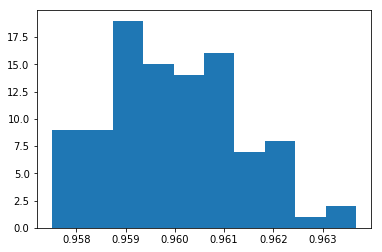

95.0 confidence interval 95.8% and 96.3%


In [13]:
from matplotlib import pyplot
# plot scores
pyplot.hist(stats)
pyplot.show()
# confidence intervals
alpha = 0.95                             # for 95% confidence 
p = ((1.0-alpha)/2.0) * 100              # tail regions on right and left .25 on each side indicated by P value (border)
lower = max(0.0, np.percentile(stats, p))  
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))